# chapter 11. Training Deep neural nets

- 고해상도의 이미지에서 수백가지 유형의 객체를 감지해야 하는 것 처럼 복잡한 문제는 어떻게 해결할까?
- 훨씬 어려운 DNN 학습이 필요할 수 있으며 이러한 작업은 쉬운일이 아닌다. 몇가지 이유는 다음과 같다.
  - 기울기가 사라지는 (vanishing gradients) 문제 혹은 발산해버리는 (exploding gradients) 문제에 직면하게 되어 하위 레이어에서 학습하는 것을 매우 어렵게 만듦
  - 대규모 네트워크에서 학습은 매우 느림
  - 수백만 개의 파라미터가 있는 모델은 학습 세트를 오버피팅 할 위험이 있음
- 이번 장에서는 이러한 문제들을 각각 살펴보고 해결할 기술을 제시한다.
  - 기울기가 사라지는 문제 설명, 대중적으로 사용하는 해결책을 모색
  - 다양한 기울기 하강법을 비교하여 대용량 모델을 빠르게 학습할 수 있는 다양한 최적화 기법에 대해 살펴 봄
  - 대규모 신경망에 대한 몇 가지 인기있는 정규화 기법에 대해 살펴 봄

In [10]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 1. Vanishing & Exploding Gradients Problems
- 역전파(backpropagation)알고리즘은 아웃레이어에서 인풋레이어로 이동하면서 Error gradient를 전파한다.
- 알고리즘은 네트워크의 각 파라미터와 관련하여 비용함수의 기울기를 계산하여 각 파라미터를 gradient descent 단계로 갱신한다
- 알고리즘이 하위 레이어로 진행함에 다라 기울기는 점점 작아진다. 즉, 레이어를 지날 때마다 최초 값보다 현저하게 작아지기 때문에 값을 전달해도 의미가 없다. -> 좋은 솔루션 아님. ---> **"Vanishing gradient 문제"**
- 기울기가 커지는 반대의 경우도 발생하기 때문에 알고리즘은 발산하게 되는데 이를 ---> **"Exploding gradients 문제"** (14장 RNN에서 주로 발생하는 문제)

- 2010년,  Xavier Glorot와 Yoshua Bengio가 작성한 "Understanding the Difficulty of Traning Deep FeedForward Neural etworks"라는 제목의 논문에서 몇 가지 의문점(suspects)을 발견하였다. 
  - 당시 인기있었던 logistic sigmoid 활성화 함수와 평균 0과 표준편차 1의 정규분포를 사용하는 무작위 초기화로 사용된 가중치 초기화(weight initialization)를 포함.
  - 시그모이드 활성화 함수와 initialization을 통해 각 레이어의 아웃풋의 분산이 인풋의 분산보다 훨씬 크다는 것을 보여주었다.


In [11]:
def logit(z):
    return 1 / (1+np.exp(-z))

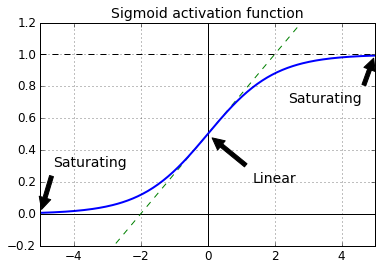

In [12]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0,0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

- logistic 활성화 함수를 보면 input 값이 커지면(음수 또는 양수)함수가 0 또는 1로 포화되고 도함수(미분계수)는 0에 가까워짐을 알 수 있다.
- 따라서, 역전파가 시작 될 때, 네트워크를 통해 다시 전파 될 수 있는 gradient가 거의 없다. 역전파가 최상위 레이어를 통해 진행됨에 따라 gradient는 희박해지기 때문에 하위 레이어에는 아무 것도 남지 않는다.    ---(?)

### 1.1 Xavier and He Initialization

- Glorot과 Bengio는 이 문제를 완화시키는 방법을 제안한다.
- 신호가 양방향. 즉, 예측할 때 앞 방향으로, gradient를 역전파 할 때 반대 방향으로 적절히 흐르는 것을 필요로 한다.
- layer가 동일한 input의 수와, output connection을 가지고 있지 않으면 보장 할 수는 없지만, 실제로 잘 잘동하는 것으로 입증 된 좋은 절충안을 제안했다.
  - n_inputs과 n_outputs은 가중치가 초기화되는 input 및 output의 connections 수이다.(fan-in과 fan-out 이라고도 함)
  - 이 초기화 전략은 Xavier initialization 또는 Glorot initialization 이라고도 한다.
  - input 과 output의 연결 수가 대략 같으면 보다 간단한 방정식을 얻을 수 있다.
  <img src='11-1.png'>
  
  - Xavier 초기화 전략을 사용하면 학습 속도가 상당히 빨라 질 수 있고 이는 딥러닝의 성공을 이끌어낸 트릭 중 하나이다. 
  - ReLU 활성화 함수에 대한 초기화 전략은 He initialization 이라고도 부른다.
  
  
- 10장의 tf,layers.dense()함수는 균일 분포(uiform distribution)인 Xavier initialization을 사용. 아래와 같이 variance_scaling_initialization()함수를 사용하여 He initialization으로 변경 할 수 있다.

In [13]:
import tensorflow as tf

In [14]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [15]:
he_init = tf.contrib.layers.variance_scaling_initializer()    #해당부분
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

### 1.2 Nonsaturating Activation Functions

-  Glorot과 Bengio의 2010년 논문으로부터 vanishing/exploding gradients 문제가 부분적으로 활성화 함수를 잘못 선택 되었기 때문에 발생한 것이라는것을 알 수 있었다. 
- 이 때까지만 해도, 대부분의 사람들은 생물학적 뉴런에서 sigmoid 활성화 함수를 사용하기로 결정하면, 훌륭한 선택일것이라고 생각했다.
- 그러나 Deep Neural Network(DNN) 에서 다른 활성화 함수, 특히 ReLU 활성화 함수는 특히 더 잘 작동한다는 사실이 드러났다. ReLU 활성화 함수는 양수(positive) 값에 대해 포화되지 않기 때문이다. (또한 계산 속도가 매우 빠름)


- 하지만  ReLU 활성화 함수는 완벽하지는 않다. 이것은 "Dying ReLUs'로 알려진 문제로 인한 것이다. : 학습하는 동안 몇몇 뉴런은 실제적으로 죽게되는데, 이는 0이외에 다른 값의 출력을 하지 않는 것을 의미한다.(ReLU 함수는 0보다 낮은 값에서 Gradient 값은 0으로만 출력됨)
- 경우에 따라서, 네트워크 학습 뉴런의 절만이 죽어있을 수도 있다.(특히, 학습률이 클수록)
- 학습도중 뉴런의 입력 가중치의 합이 음수가 되도록, 뉴런의 가중치가 업데이트 된다면 이는 0을 출력하게 될 것이다. 
- 이 문제를 해결하기 위해 leaky ReLU와 같은 변형된 ReLU함수를 사용할 수 있다.

<img src='11-2.png'>


- 위와 같이 정의 할 수 있다.
  - 파라미터 알파는 함수가 얼마나 많이 leaks 하는 지에 대해 정의한다.
  - z<0 에 대한 함수의 gradient이며, 일반적으로 0.01로 설정된다.
 
 
- 논문에서는 ReLU 활성화 함수의 여러 변종에 대해 비교를 했고, 결론 중 하나는 leaky ReLU 가 strict ReLU보다 우월하다는 것이다. 실제로 α=0.01(small leak)보다 성능이 좋게 나왔다.
- 또한 randomized leaky ReLU(RReLU)에 대해서도 평가를 하였다. 여기에서 α는 학습 중 주어진 범위에서 무작위로 추출되며 테스트를 할 때에는 평균 값으로 고정된다. RReLU는 상당히 잘 수행되었고, regularizer 로써의 역할을 수행한다. 즉, 트레이닝 세트에서 과적합 되는 위함을 줄일 수 있었다.
- 마지막으로 parametric leaky ReLU(PReLU)를 평가하였다. PReLU에서 α는 역전파에 의해 수정 될 수 있는 파라미터 값으로 학습 하는 동안 배울 수 있다. PReLU는 큰 이미지 데이터 세트에서 ReLU보다 강력하고 뛰어난 것으로 보고되었지만, 작은 이미지 데이터 세트에서는 학습셋이 과적합 될 수 있는 위험이 있다.

- 텐서플로우에는 leaky ReLU에 대해 미리 정의된 함수는 없지만 정의하기 매우 쉽다.
- alpha 값으로는 0.01로 설정

In [16]:
def leaky_relu(z, alpha=0.01):     #alpha
    return np.maximum(alpha*z, z)

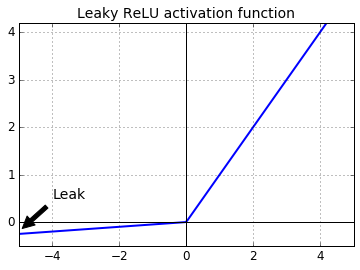

In [17]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [18]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [19]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1") #activation=leaky_relu 구현


In [20]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [21]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [22]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [23]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [24]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [25]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [26]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [28]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.951
10 Batch accuracy: 0.96 Validation accuracy: 0.9666
15 Batch accuracy: 1.0 Validation accuracy: 0.972
20 Batch accuracy: 1.0 Validation accuracy: 0.9748
25 Batch accuracy: 1.0 Validation accuracy: 0.9764
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 0.96 Validation accuracy: 0.9792


#### ELU

- 2016년 Djork-Arne Clevert의 논문에서 모든 ReLU의 변형을 능가하는 새로운 활성화 함수 Exponential linear unit(ELU)를 제안했다.
- ELU는 학습 시간을 단축하고, 신경망이 테스트 세트에서 더 잘 수행됨을 확인하였다. ELU의 식과 그래프는 다음과 같다.

<img src='11-3.png'>


- ELU는 ReLU의 기능과 비교하면 몇 가지 큰 차이점을 제외하고는 비슷하다.
  - (1) Z<0 일 때, 음의 값을 취한다. 단위가 0에 가까운 평균 출력을 갖는다. 이는 이전에 논의된 것처럼 vanishing gradient(기울기가 사라지는) 문제를 완화하는데 도움이 된다. 파라미터  α는 Z가 큰 음수일 때 ELU 함수가 접근하는 값을 정의한다. 일반적으로 1로 설정되지만, 다른 파라미터처럼 조정 가능하다.
  - (2) Z<0에 대해 0이 아닌 기울기를 가지기 때문에, dying units 문제를 피할 수 있다.
  - (3) 함수는 Z=0 주변을 포함하여 모든 면에서 smooth 하다. 그렇기 때문에 gradient descent 의 속도를 높이는데 도움이 된다.
  
  
- ELU 활성화 함수에도 단점은 있다. 지수 함수의 사용으로 인하여 ReLU와 그 변형에 비해 느리게 계산된다. 학습동안에는 더 빠른 convergence rate로 보상을 받기는 하지만, 테스트 시간에 ELU는 ReLU보다 느리다.

**[Tip]**

활성화 함수가 상당히 많은데, 그렇다면 deep neural networks의 hidden layer에 어떤 활성화 함수를 사용해야할까?
 
일반적으로 ELU > leaky ReLU(또는 그 변형) > ReLU > tanh > sigmoid 을 사용한다고 한다.
만약 런타임 성능이 중요하다면 ELU 보다 leaky ReLU를 선호할 것이다.
만약 또 다른 파라미터를 조정하고 싶지 않다면 이전에 제안한 기본값 α를 사용할 수 있다.(leaky ReLU의 경우 0.01, ELU의 경우 1)
여유 시간과 컴퓨팅 파워가 있다면, cross validation을 이용하여 다른 활성화 함수, 특히 네트워크가 과적합하다면, RReLU를, 학습 세트가 너무 많을 경우에는 PReLU를 이용해 볼 수 있다.

In [22]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

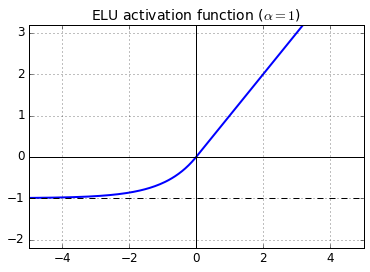

In [24]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [37]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [38]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

- 텐서플로우에는 신경망을 구축하는 데 사용할 수 있는 elu()함수를 제공.
- 위 코드와 같이 dense()함수를 호출 할 때, activation 인수를 설정하면 된다. 

### 1.3 Batch Normalization

-  2015년 Segey Ioffe와 Christian Szegedy의 논문에서 vanishing/exploding 문제를 처리하기 위해 Batch Normalization(BN)이라는 기술을 제안 
- 학습하는 동안 이전 레이어의 파라미터가 변경됨으로써, 각 레이어들의 입력 분포가 변경되는 문제 해결
  - 각 레이어의 activation function 직전 모델에 operation을 추가, 간단히 input값들을 zero-centering과 normalizing을 한다.
  - 그 다음, 레이어당 두 개의 새로운 파라미터를 사용하여 결과를 scaling 하고 shifting 하는 것으로 구성
  - 즉, 하나의 파라미터는 scaling 용이며 다른 하나는 shifting 용이다.
  - mini-batch를 통해 평균 및 표준편차를 평가하는 식은 아래와 같다.
  
  
  <img src='11-4.png'>
  
  
  - 테스트 할 때에는, 경험적 평균과 표준편차를 계산 할 mini-batch가 없으므로, 대신 전체 학습 세트의 평균 및 표준편차를 사용해야 한다. 
  - 이것들은 일반적으로 이동 평균(moving average)를 이용하여 학습 중에 효율적으로 계산된다. 따라서 전체적으로 각 batch-normalized layer에 4개의 파라미터가 학습된다. 
  - -> γ (scale), β (offset), μ(mean) 및 σ(standard deviation)
  
  
- BN에도 단점은 존재한다. 
  - 비록 batch-normalized 상태일 때에는 첫 번째 hidden layer가 이를 처리하기 때문에 input 데이터를 정규화 할 필요는 제거 되지만, 모델에 약간의 복잡성이 추가된다.
  - 또한 런타임 패널티가 있다. 신경망은 각 layer에서 필요한 추가 계산으로 인해 예측이 느려진다.
  - 따라서 만약 예측을 빠르게 해야한다면, BN을 수행하기 전에 ELU와 He initialization이 제대로 수행되는지 확인이 필요하다.

### 1.3.1  Implementing Batch Normalization with TensorFlow

-  텐서플로우는 input을 중앙에 놓고, normalize하는 tf.nn.batch_normalization() 함수를 제공하지만, 사용자가 직접 평균 및 표준편차를 계산해야 한다. (학습 중 mini-batch 데이터 또는 테스트중에 전체 데이터 셋을 기반) 그리고 파라미터를 함수에 전달하고 scaling 및 offset 파라미터의 생성을 처리해야 한다. (그리고 다시 함수에 전달) 
- 이것은 편리한 방법이 아니다. 대신 다음 코드와 같이 이 모든 것을 처리하는 tf.layers.batch_normalization() 함수를 사용하면 된다.

In [41]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [42]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [43]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [44]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 20
batch_size = 200

In [46]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8697
1 Test accuracy: 0.8988
2 Test accuracy: 0.9128
3 Test accuracy: 0.9208
4 Test accuracy: 0.9284
5 Test accuracy: 0.9366
6 Test accuracy: 0.9395
7 Test accuracy: 0.9435
8 Test accuracy: 0.9475
9 Test accuracy: 0.9506
10 Test accuracy: 0.9519
11 Test accuracy: 0.9544
12 Test accuracy: 0.9578
13 Test accuracy: 0.9575
14 Test accuracy: 0.9599
15 Test accuracy: 0.9611
16 Test accuracy: 0.9603
17 Test accuracy: 0.9636
18 Test accuracy: 0.9644
19 Test accuracy: 0.9657


In [47]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0']

In [48]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### 1.4 Gradient Clipping

In [49]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [50]:

learning_rate = 0.01

In [51]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)


In [52]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [53]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [54]:
n_epochs = 20
batch_size = 200

In [55]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.308
1 Test accuracy: 0.792
2 Test accuracy: 0.8781
3 Test accuracy: 0.902
4 Test accuracy: 0.9136
5 Test accuracy: 0.9197
6 Test accuracy: 0.9255
7 Test accuracy: 0.9309
8 Test accuracy: 0.9345
9 Test accuracy: 0.9411
10 Test accuracy: 0.9426
11 Test accuracy: 0.9461
12 Test accuracy: 0.9474
13 Test accuracy: 0.9504
14 Test accuracy: 0.9522
15 Test accuracy: 0.9533
16 Test accuracy: 0.9543
17 Test accuracy: 0.9556
18 Test accuracy: 0.9578
19 Test accuracy: 0.9592


## 2.

## 3. Faster Optimizers

-  매우 큰 심층 신경망(Deep Neural Network)을 학습하는 것은 고통스럽게 느릴 수 있다. 지금까지 학습을 가속화하고 더 나은 솔루션에 도달하는 4가지 방법에 대해 알아봤었다. 4가지라 함은, 
1) Applying a good initialization strategy for the connection weights
2) Using a good activation function
3) Using Batch Normalization
4) Reusing parts of a pretrained network 이다.

-  또 다른 속도 향상 방법으로 regular Gradient Descent optimizer보다 빠른 optimizer를 선택하는 방법이 있다. 이번 섹션에서는 가장 인기있는 것들에 대해 제시하고자 한다.
   
   - Momentum optimization
   - Nesterov Accelerated Gradient
   - AdaGrad
   - RMSProp
   - Adam optimization

### 3.1 Momentum optimization

- 1964년 Polyak이 제안하였음. 볼링공의 경사면에서 굴러떨어지는 것에서 아이디어 얻음.이전 기울기가 무엇인지에 대해 크게 영향을 받는다.
- 각 반복에서 momentum 벡터 m(learning rate η으로 곱한)에서 local gradient를 뺀 다음 이 momentum벡터를 단순히 추가하여 가중치를 업데이트 한다. 
- 즉, 속도가 아닌 가속도를 이용한다. 

<img src='11-5.png'>

- 어떤 종류의 마찰 메커니즘을 시뮬레이션하고 운동량이 너무 커지지 않도록 하기 위해, 알고리즘은 0(high friction)과 1(no friction) 사이에서 설정해야 하는 momentum이라는 새로운 파라미터 β를 도입한다.
- 일반적인 momentum 값은 0.9다
-  Gradient가 일정하게 유지되면 terminal velocity(즉, 가중치 업데이트의 최대크기)가 learning rate η에 1/(1-β)를 곱한 값(부호 무시)에 gradient를 곱한것과 동일한지에 대해 쉽게 확인할 수 있다.
- 신층신견망의 경우 Batch normalization을 사용하지 않기 때문에 상위 레이어는 종종 매우 다른 스케일의 입력을 갖는다. 이 때 momentum optimization을 사용하면 많은 도움이 된다.


- 한 가지 단점은, 튜닝 할 파라미터가 추가된다는 것이다. 그러나 momentum 값 0.9는 일반적으로 잘 잘독하며 거의 항상 gradient descent 보다 빠르다.



In [56]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

### 3.2 Nesterov Accelerated Gradient

- 1983년 Yurii Nesterov가 제안한 momentum optimization의 변형은 vanilla momentum optimization(? 3.1) 보다 항상 빠르다.
- Nesterov Accelerated Gradient(NAG)는 비용함수의 기울기를 local position이 아닌, momentum의 방향으로 약간 앞당기는 아이디어
- vanilla momentum optimization과의 유일한 차이점은 기울기 θ가 아닌 θ+βm 에서 측정된다는 것
- 원래 위치에서 gradient를 사용하는 대신, 그 방향으로 조금 더 멀리 측정 한 gradient를 사용하는 것이 좀 더 정확하다. 
  (∇1은 시작 포인트 θ에서 측정된 비용함수의 기울기를 나타내며, ∇2는 θ+βm에 위치한 점의 기울기를 나타낸다).
  
  <img src='11-6.png'>
  
  - 부가설명 필요. 질문 !

In [58]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

### 3.3 AdaGrad

- 본 알고리즘은 가장 가파른 차원을 따라 기울기 벡터를 축소함으로써 이를 달성한다.

<img src='11-7.png'>

-  첫 번째 단계는 Gradient의 제곱을 벡터 s에 축적한다. (⊗ 기호는 요소별 곱셈(element-wise multiplication을 나타냄) 이 vectorized form은 벡터 s 의 각 요소 si에 대해 s_i ← s_i + (∂J (θ) / ∂ θ_i)^2 를 계산하는 것과 같다. 즉, 각 s_i는 파라미터 θ_i에 대한 비용 함수의 편미분의 제곱을 누적한다. 만약 비용 함수가 i 번째 차원에서 가파른 경우, s_i는 반복 할 때마다, 더욱 커지고 커질 것이다.

-  두 번째 단계는 Gradient Descent와 거의 동일하지만 큰 차이점이 있다. Gradient 벡터는 루트(s+ε)의 인수로 축소된다. (⊘ 기호는 요소 단위의 분할(element-wise division)을 나타내고 ε은 0으로 나누는 것을 피하기 한 smoothing term이며, 일반적으로 10의 -10승으로 설정됨)


<img src='11-8.png'>

-  resulting updates를 global optimum을 향해 보다 직접적으로 가리킬 수 있다. 또한 추가적인 이점으로 learning rate 파라미터 η의 튜닝이 훨씬 덜 필요하다는 것이다.


In [59]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

### 3.4 RMSProp

-  3.3의 AdaGrad가 너무 느려지고 global optimum으로 수렴하지 못하는 경우에도 RMSProp알고리즘은 가장 최근 반복의 gradient만 축적함으로써 이를 수정한다. 

<img src='11-9.png'>

- 첫 번째 단계에서 지수적 감쇠(exponential decay)를 사용하여 수행
- 감쇠율(decay rate) β는 일반적으로 0.9로 설정된다. 이것은 새로운 파라미터이다. 그러나 베타값 0.9는 일반적으로 잘 동작하기 때문에 조정할 필요가 전혀 없을 수도 있다. 텐서플로우에는 RMSPropOptimizer클래스가 있다.
- 3.1 이나 3.2 보다 빠르게 수렵하고, 3.3 보다 잘 작동하여 많은 연구자들이 선호하는 최적화 알고리즘 이다.

In [60]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

### 3.5 Adam Optimization

-  Adaptive moment estimation을 나타내는 Adam은 momentum optimization과 RMSProp의 아이디어를 결합하였다

<img src='11-10.png'>

- T는 반복 횟수를 나타낸다. 1부터 시작함.
-  1,2,5 단계만 보면 Adam optimization이 Momentum optimization과 RMSProp과 유사하다는 것을 알 수 있다.
- 유일한 차이점은 단계1에서 exponentially decaying sum이 아닌 exponential decaying average를 계산한다는 것이다.  그러나 이는 상수 요소(constant factor)을 제외하고는 실제로 동일하다.(decaying average는 단지 decaying sum의 (1-β_1)배다.)
- 3단계와 4단계는 다소 기술적인 세부사항이다. m과 x는 0에서 초기화되기 때문에 학습 시작시 0에 편향되므로, 이 두 단계는 학습 시작 시 m과 x를 향상시키는 데 도움이 된다. 
-  Adam은 AdaGrad와 RMSProp과 같은 adaptive learning rate 알고리즘이기 때문에, learning rate 파라미터 η의 조정이 덜 필요하다. 기본값인 0.001을 사용하면 Adam을 Gradient Descent보다 더 쉽게 사용할 수 있다.

In [61]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### 3.6 Learning Rate Scheduling

<img src='11-11.png'>

-  좋은 Learning rate를 찾는 것은 다소 까다로울 수 있다. 너무 높게 설정하면 발산(diverge)할 수 있다. 
-  너무 낮게 설정하면 학습은 결국 optimum으로 수렴은 되지만, 매우 오랜 시간이 걸릴 것이다.  
- 약간 높게 설정하면 처음에는 매우 빠르게 진행되지만, optimum 근처에서 매우 여기저기 움직이며 끝나지 않을 것이다. 
- 만약 높은 learning rate로 시작한 다음, 빠르게 진행하지 않을 때, learning rate를 줄이면 최적의 constant learning rate보다 빠른 속도로 좋은 솔루션에 도달 할 수 있다. 
- 학습 중 learning rate를 줄이기 위한 여러가지 전략이 있다. 이러한 전략을 learning schedules 이라고 부른다. 
  - (1)예정된 구분 상수 학습률: 학습 률을 처음에는 η0 = 0.1로 설정하고 50 에포크 이후에는 η1 = 0.001로 설정. 효과적일 수는 잇지만 적절한 학습 속도와 사용시기를 파악하기 위해 항상 주의를 기울여야 한다.
  - (2)성능 스케줄링: N단계마다 유효성 검증 오류를 측정하고 오류가 중단되지 않을때 학습률을 λ만큼 줄인다.
  - (3)지수적 스케줄링: 학습속도를 반복 수 t의 함수로 설정.t: η(t) = η_0 10^(– t/r). 훌륭하게 작동 하지만  η_0과 r을 튜닝해야한다. 학습속도는 매 단계마다 10배 떨어진다.
  - (4)동력 스케줄링: 학습속도를 η(t) = η_0 (1 + t/r)^–c.로 설정한다. 하이퍼매개변수 c는 일반적으로 1로 설정된다. 이것은 지수 일정과 비슷하지만 학습속도가 훨씬 느려진다.

In [62]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

- 아래코드 설명.
  - 파라미터 값을 설정 한 후에는 현재 학습 반복 횟수를 추적하기 위해 nontrainable 변수 global_step(0으로 초기화) 을 생성한다. 
  - 그런 다음 텐서플로우의 exponential_decay() 함수를 사용하여 기하급수적으로 감소하는 learning_rate를 정의한다. (η0 = 0.1 및 r = 10,000)
  - 다음으로, 이 감소하는 learning_rate를 사용하여 optimizer를 만든다.(이 예제에서는 momentum optimizer)
  - 마지막으로 optimizer의 minimize() 메소드를 호출하여 학습 operation을 만든다

In [63]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [64]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [65]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9595
1 Test accuracy: 0.9749
2 Test accuracy: 0.9753
3 Test accuracy: 0.9783
4 Test accuracy: 0.9819
